In [24]:
# load pandas and numpy
import pandas as pd
import numpy as np
import re
import os
import sys
import seaborn as sns

def get_tables(is_covariates, models, datasets, time_steps):
    # create dataframes for MSE and MAE with columns for each dataset and rows for each model
    df_rmse = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] + 
                        [dataset + ' OOD' for dataset in datasets], index=models)
    df_mae = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OOD' for dataset in datasets], index=models)
    df_likelihood = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OOD' for dataset in datasets], index=models[1:]) # no likelihood for ARIMA
    df_calibration = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OOD' for dataset in datasets], index=models[1:]) # no calibration for ARIMA
    for model in models:
        for dataset in datasets:
            filename = f"../output/{model}_{dataset}.txt" if not is_covariates else f"../output/{model}_covariates_{dataset}.txt"

            if not os.path.isfile(filename):
                print(filename)
                continue

            with open(filename, 'r') as f:
                for line in f:
                    if line.startswith('ID median of (MSE, MAE):'):
                        id_mse_mae = re.findall(r'\d+\.\d+', line)
                        df_rmse.loc[model, dataset + ' ID'] = float(id_mse_mae[0])**0.5
                        df_mae.loc[model, dataset + ' ID'] = float(id_mse_mae[1])
                    elif line.startswith('OOD median of (MSE, MAE):'):
                        ood_mse_mae = re.findall(r'\d+\.\d+', line)
                        df_rmse.loc[model, dataset + ' OOD'] = float(ood_mse_mae[0])**0.5
                        df_mae.loc[model, dataset + ' OOD'] = float(ood_mse_mae[1])
                    elif line.startswith('ID likelihoods:'):
                        id_likelihoods = re.findall(r'-?\d+\.\d+', line)
                        df_likelihood.loc[model, dataset + ' ID'] = float(id_likelihoods[0])
                    elif line.startswith('OOD likelihoods:'):
                        ood_likelihoods = re.findall(r'-?\d+\.\d+', line)
                        df_likelihood.loc[model, dataset + ' OOD'] = float(ood_likelihoods[0])
                    elif line.startswith('ID calibration errors:'):
                        id_calib = re.findall(r'-?\d+\.\d+', line)
                        id_calib = np.mean([float(x) for x in id_calib[:time_steps]])
                        df_calibration.loc[model, dataset + ' ID'] = id_calib
                    elif line.startswith('OOD calibration errors:'):
                        ood_calib = re.findall(r'-?\d+\.\d+', line)
                        ood_calib = np.mean([float(x) for x in ood_calib[:time_steps]])
                        df_calibration.loc[model, dataset + ' OOD'] = ood_calib
    
    # sort columns for all dataframes
    df_rmse = df_rmse.reindex(sorted(df_rmse.columns), axis=1)
    df_mae = df_mae.reindex(sorted(df_mae.columns), axis=1)
    df_likelihood = df_likelihood.reindex(sorted(df_likelihood.columns), axis=1)
    df_calibration = df_calibration.reindex(sorted(df_calibration.columns), axis=1)

    return df_rmse, df_mae, df_likelihood, df_calibration

models = ['arima', 'nhits', 'tft', 'linreg', 'xgboost', 'transformer']
datasets = ['weinstock', 'dubosson', 'colas', 'iglu', 'hall']
time_steps = 12

df_nocov_rmse, df_nocov_mae, _, _ = get_tables(False, models, datasets, time_steps) 

nocovmodels = [m for m in models if m != "arima"]
df_cov_rmse, df_cov_mae, _, _ = get_tables(True, models, datasets, time_steps) 

../output/arima_covariates_weinstock.txt
../output/arima_covariates_dubosson.txt
../output/arima_covariates_colas.txt
../output/arima_covariates_iglu.txt
../output/arima_covariates_hall.txt


Mean of all errors (no cov):  9.726042182631375
(5%, 95%) percentile of all errors (no cov):  (4.541400855580966, 15.42294610063235)


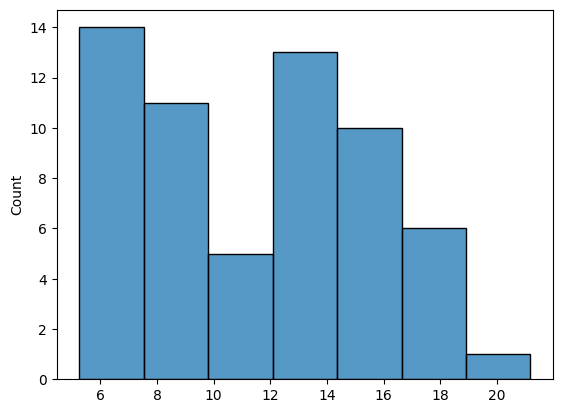

In [25]:
# 1. Range of errors
sns.histplot(df_nocov_rmse.stack()) # how to calculate 95% error bars if data isn't normal?
# sns.histplot(df_cov_rmse.stack()) # how to calculate 95% error bars if data isn't normal?

print("Mean of all errors (no cov): ", df_nocov_mae.stack().mean())
print("(5%, 95%) percentile of all errors (no cov): ", (np.percentile(df_nocov_mae.stack().to_numpy(), 5), np.percentile(df_nocov_mae.stack().to_numpy(), 95)))

# print("Mean of all errors (cov): ", df_cov_mae.stack().mean())
# print("Std of all errors (cov): ", df_cov_mae.stack().std())

(0.33359310327408315, -2.25779151941322, 3.1055639707044493)

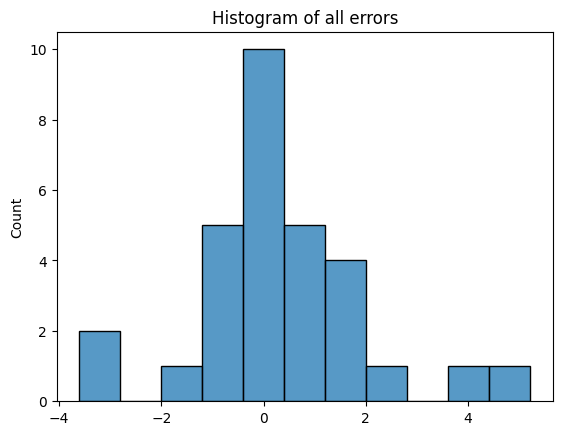

In [63]:
# 2. ID compared to OOD - axis along datasets
ood_minus_id = np.zeros(0)
for dataset in datasets:
    delta = df_nocov_rmse[f"{dataset} OOD"] - df_nocov_rmse[f"{dataset} ID"]
    ood_minus_id = np.append(delta, ood_minus_id)

sns.histplot(ood_minus_id).set_title("Histogram of all errors")
(np.mean(ood_minus_id), np.percentile(ood_minus_id, 5), np.percentile(ood_minus_id, 95))


arima 1.723026697589809 -0.3074093685740996 4.6686376605513935
nhits 0.5262523073627404 -0.19305515388490802 1.156979096906574
tft -0.2293878420823507 -1.2187525270500656 0.7840537698771884
linreg 1.2862244493021975 0.11201212459936123 3.2921434056019336
xgboost -1.0469888907400844 -3.4884141311525765 1.3671783640291166
transformer -0.25756810178781303 -1.0501338968384928 0.7991626465489605


,arima,nhits,tft,linreg,xgboost,transformer
0,-0.413509,0.06138,0.205082,0.476846,-0.086206,0.290757
1,1.220167,0.846297,-1.30649,0.293086,-3.036129,-1.083231
2,0.116988,-0.256664,-0.106525,0.066744,-0.241648,-0.503885
3,5.217234,0.745599,-0.867804,3.62209,-3.601485,-0.917747
4,2.474254,1.23465,0.928797,1.972356,1.730524,0.926264


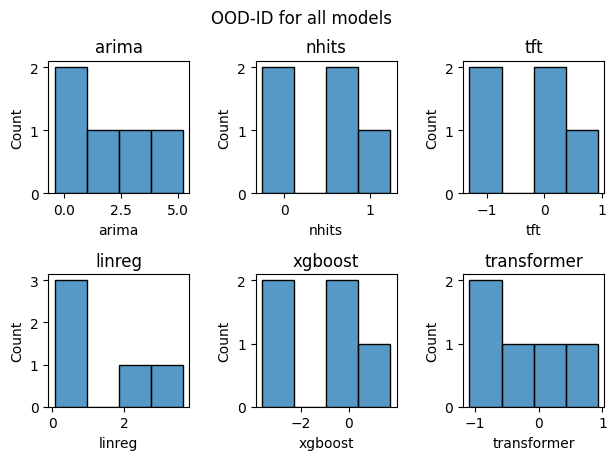

In [62]:
# 2. ID compared to OOD - axis along datasets
differences = pd.DataFrame()
for model in models:
    ood_minus_id = np.zeros(0)
    for dataset in datasets:
        delta = df_nocov_rmse.filter(items=[model], axis=0)[f"{dataset} OOD"] - df_nocov_rmse.filter(items=[model], axis=0)[f"{dataset} ID"]
        ood_minus_id = np.append(delta, ood_minus_id)

    differences[model] = ood_minus_id

import matplotlib.pyplot as plt

i = 2
j = 3
fig, ax = plt.subplots(i,j)

for n, (key, val) in enumerate(differences.items()):
    # print(n, n//j, n%j)
    sns.histplot(differences[key], ax=ax[n//j, n%j]).set_title(key)
    print(key, np.mean(val), np.percentile(val, 5), np.percentile(val, 95))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("OOD-ID for all models")

differences

<AxesSubplot: xlabel='model', ylabel='error'>

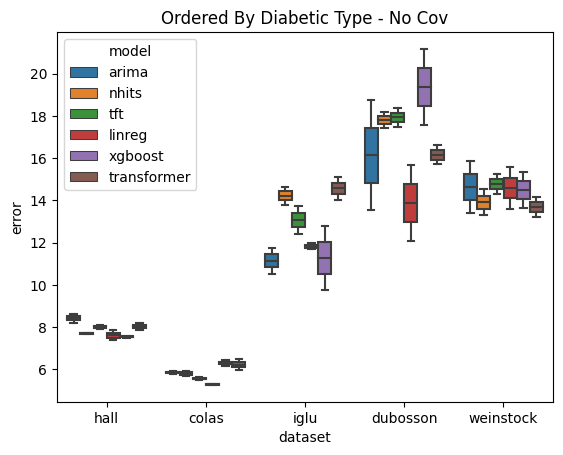

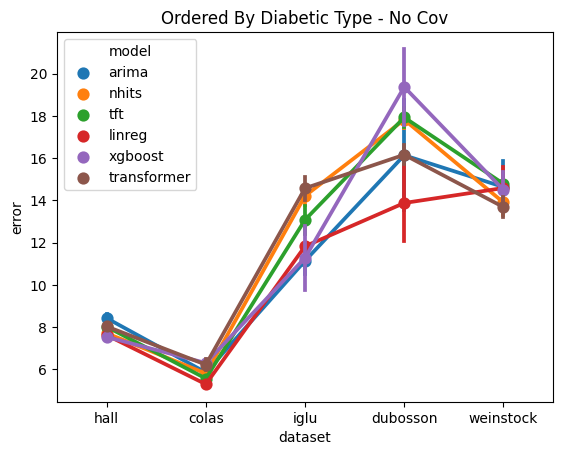

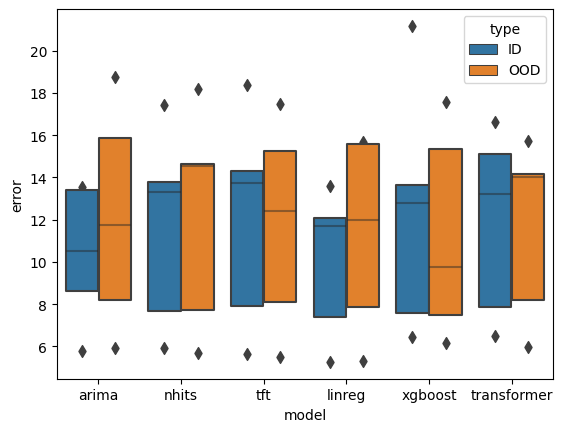

In [161]:
# 3. LOTS OF PLOTS

# prepare the data
def prepare_data(df):
    df = df.stack().reset_index()
    df["type"] = df["level_1"].apply(lambda x: "ID" if "ID" in x else "OOD")
    df.columns = ["model", "dataset", "error", "type"]
    df["dataset"] = df["dataset"].apply(lambda x: x.split(" ")[0])
    return df

df1 = prepare_data(df_nocov_rmse)

# 3a.Ordered by difficulty
plt.figure()
sns.boxplot(df1, x=df1["dataset"], y="error", hue=df1["model"], order=["hall","colas","iglu","dubosson","weinstock"]).set_title("Ordered By Diabetic Type - No Cov")

plt.figure()
sns.pointplot(df1, x=df1["dataset"], y="error", hue=df1["model"], order=["hall","colas","iglu","dubosson","weinstock"]).set_title("Ordered By Diabetic Type - No Cov")

#  ID vs. OOD
plt.figure()
sns.boxenplot(df1, x="model", y="error", hue="type")


